In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read in the data
df = pd.read_csv('data/ETTh1.csv')
df.tail()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778
17419,2018-06-26 19:00:00,10.114,3.550,6.183,1.564,3.716,1.462,9.567


In [3]:
from src.scaler import Scaler
from src.dataset import TimeSeriesDataset

input_field = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL']
output_field = ['OT']
timeseries_field = input_field + output_field

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

num_rows = len(df)
train_end_index = int(train_ratio*num_rows)
val_end_index = int((train_ratio + val_ratio)*num_rows)

train_df = df.iloc[:train_end_index]
val_df = df.iloc[train_end_index:val_end_index]
test_df = df.iloc[val_end_index:]

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

scaler = Scaler(train_df[timeseries_field], 'minmax')

trainSet = TimeSeriesDataset(train_df, input_field, output_field, scaler, seq_len=64)
valSet = TimeSeriesDataset(val_df, input_field, output_field, scaler, seq_len=64)
testSet = TimeSeriesDataset(test_df, input_field, output_field, scaler, seq_len=64)

In [13]:
input_field = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL']
output_field = ['OT']
timeseries_field = input_field + output_field
train_maxs = train_df[timeseries_field].max()
train_mins = train_df[timeseries_field].min()

In [14]:
train_df[timeseries_field] = (train_df[timeseries_field] - train_mins)/(train_maxs - train_mins)

In [16]:
train_maxs

HUFL    23.643999
HULL    10.114000
MUFL    17.341000
MULL     7.569000
LUFL     8.498000
LULL     3.046000
OT      46.007000
dtype: float64

In [17]:
train_mins

HUFL   -19.625
HULL    -4.756
MUFL   -21.961
MULL    -5.934
LUFL    -1.188
LULL    -1.371
OT      -4.080
dtype: float64

In [15]:
train_df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,0.588227,0.454943,0.599461,0.473673,0.556576,0.613765,0.691018
1,2016-07-01 01:00:00,0.585130,0.459449,0.596738,0.471006,0.550279,0.620783,0.636233
2,2016-07-01 02:00:00,0.572743,0.436920,0.591319,0.465748,0.512595,0.586144,0.636233
3,2016-07-01 03:00:00,0.571194,0.450437,0.591319,0.468414,0.515693,0.599955,0.581468
4,2016-07-01 04:00:00,0.577388,0.450437,0.596738,0.473673,0.521990,0.599955,0.519656


In [4]:
train_df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [8]:
from src.dataset import TimeSeriesDataset
from src.forecast_models import LSTMForecaster
from src.train import train
from torch.utils.data import DataLoader
import torch

input_field = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL']
output_field = ['OT']

if torch.cuda.is_available():
    device =  torch.device('cuda')
else:
    device =  torch.device('cpu')

dataset = TimeSeriesDataset(df, input_field, output_field, seq_len=10)

input_size = len(input_field)
output_size = len(output_field)

model = LSTMForecaster(input_size, 128, 2, output_size, dropout=0.2)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

optimizer =  torch.optim.Adam(model.parameters(), lr=1e-4)
critertion = torch.nn.MSELoss()

for epoch in range(1, 100):
    train_loss = train(dataset, model, critertion, optimizer, device=device, batch_size=32, epoch=epoch)
    print('Epoch {} completed: \nTrain loss: {:.4f}'.format(epoch, train_loss))


Epoch[1](200/545) Loss: 157.916656
Epoch[1](400/545) Loss: 88.045235
Epoch 1 completed: 
Train loss: 109.6036
Epoch[2](200/545) Loss: 104.726990
Epoch[2](400/545) Loss: 108.698021
Epoch 2 completed: 
Train loss: 87.0144
Epoch[3](200/545) Loss: 88.865982
Epoch[3](400/545) Loss: 58.708710
Epoch 3 completed: 
Train loss: 78.6465
Epoch[4](200/545) Loss: 83.029892
Epoch[4](400/545) Loss: 112.977768
Epoch 4 completed: 
Train loss: 82.1119
Epoch[5](200/545) Loss: 102.881599
Epoch[5](400/545) Loss: 95.649971
Epoch 5 completed: 
Train loss: 84.5765
Epoch[6](200/545) Loss: 99.731110
Epoch[6](400/545) Loss: 23.863377
Epoch 6 completed: 
Train loss: 79.4066
Epoch[7](200/545) Loss: 101.610260
Epoch[7](400/545) Loss: 48.843990
Epoch 7 completed: 
Train loss: 80.9137
Epoch[8](200/545) Loss: 92.915146
Epoch[8](400/545) Loss: 68.305382
Epoch 8 completed: 
Train loss: 84.6611
Epoch[9](200/545) Loss: 61.108139
Epoch[9](400/545) Loss: 128.948105
Epoch 9 completed: 
Train loss: 81.0062
Epoch[10](200/545) L

KeyboardInterrupt: 

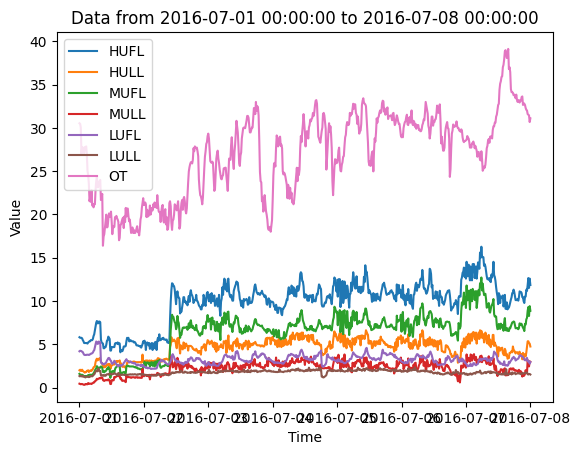

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_csv_by_time(csv_path, start_time, end_time):
    # Load CSV file into a pandas dataframe
    df = pd.read_csv(csv_path, parse_dates=['date'], index_col=['date'])
    
    # Select rows within the specified time range
    df = df.loc[start_time:end_time]
    
    # Generate a line plot for each column in the dataframe
    for col in df.columns:
        plt.plot(df.index, df[col], label=col)
    
    # Set plot title and axis labels
    plt.title(f"Data from {start_time} to {end_time}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    
    # Display legend and show plot
    plt.legend()
    plt.show()


plot_csv_by_time('data/ETTm1.csv', '2016-07-01 00:00:00', '2016-07-08 00:00:00')